# Generate artificial data

> This file doesn't need to be executed, the right .csv files should be already in this folder to run the example.
This jupyer notebook exist, to show how the artificial data is generated.

To test the program and the underlying algorithms, it is useful to generate artificial data with known refractive index and absorption. Then, the program can be better evaluated how close it comes to the "true" solution.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter

home_dir = os.getcwd()
os.chdir(r"../..")
# Own library
import phoeniks as pk
os.chdir(home_dir)

In [2]:
%matplotlib notebook

Generate a random number generator `rng` with a fixed seed, to get consistent data when the notebook is restarted. Also create a 100 ps long time vector as well as a signal, consisting of a gaussian function localized at +20 ps.

In [3]:
rng = np.random.default_rng(1234)
time = np.linspace(0, 100e-12, 4096 + 2)
signal = -pk.gaussian(time, 0.2e-12, 20e-12)

Let's check what we created and take the first and second derivative of it:

<IPython.core.display.Javascript object>


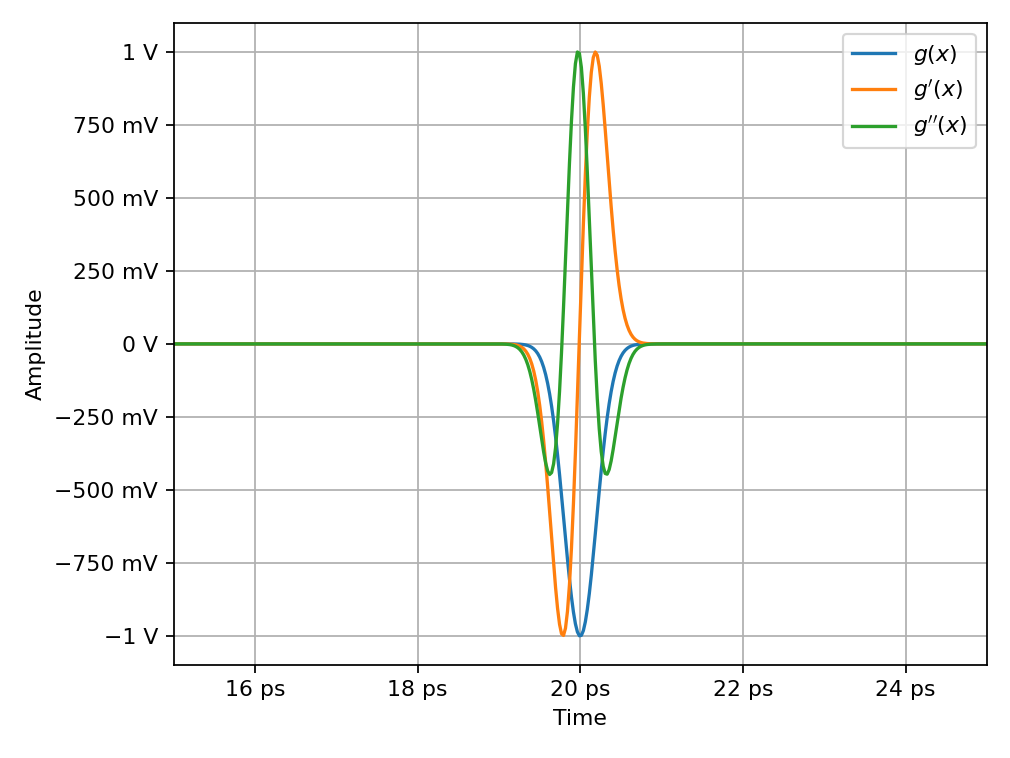

In [4]:
plt.figure()
plt.plot(time, -signal / np.min(signal), label=r"$g(x)$")
plt.plot(time[:-1], np.diff(signal, n=1) / np.max(np.diff(signal, n=1)), label=r"$g'(x)$")
plt.plot(time[:-2], np.diff(signal, n=2) / np.max(np.diff(signal, n=2)), label=r"$g''(x)$")
plt.xlim([15e-12, 25e-12])
plt.gca().legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(EngFormatter("s"))
plt.gca().yaxis.set_major_formatter(EngFormatter("V"))
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.tight_layout()
# plt.savefig("Plot0.png", transparent=False, dpi=300)

We need a few classes and functions to help to create an artifical material (based on a dielectric function):

In [8]:
# Take the second derivative of the gaussian function
signal_diff = np.diff(signal, n=2)
# Normalize
signal_norm = signal_diff / np.max(signal_diff)
# Create standard, normal-distributed noise and reduce its strength to 1e-5
dark_td = 1e-5 * rng.standard_normal(len(signal_norm))
# Add it to the normed signal
signal_norm += dark_td
# Due to the second derivative, the time trace needs to be reduced in length
time = time[:-2]
# Create frequency vector
f = np.fft.rfftfreq(len(time), (time[-1] - time[0]) / (len(time) - 1))
# Circular frequency vector
omega = 2 * np.pi * f
# Reference pulse in time domain
reference_pulse_td = signal_norm
# Reference pulse in frequency domain
reference_pulse_fd = np.fft.rfft(reference_pulse_td)

## Create an artificial material
The dielectric function can be described by various lorentz-oscillators:

In [9]:
epsilon_infinity = 3

diel = pk.Dielectric(epsilon_infinity)
diel.add_lorentz(
    central_frequency=np.array([1, 2, 2.1, 3]) * 1e12 * 2 * np.pi,
    damping_rate=np.array([0.1, 0.02, 0.3, 0.5]) * 1e12 * 2 * np.pi,
    strength=np.array([0.01, 0.002, 0.003, 0.03])
)
diel.get_eps_function()

\chi_{1}*\omega_{1}**2/(I*\gamma_{1}*\omega - \omega**2 + \omega_{1}**2) + \chi_{2}*\omega_{2}**2/(I*\gamma_{2}*\omega - \omega**2 + \omega_{2}**2) + \chi_{3}*\omega_{3}**2/(I*\gamma_{3}*\omega - \omega**2 + \omega_{3}**2) + \chi_{4}*\omega_{4}**2/(I*\gamma_{4}*\omega - \omega**2 + \omega_{4}**2) + \epsilon_{\infty}

The values of the variables can be accessed by `get_eps_guess()`

In [10]:
diel.get_eps_guess()

{'\\epsilon_{\\infty}': 3,
 '\\omega_{1}': 6283185307179.586,
 '\\gamma_{1}': 628318530717.9586,
 '\\chi_{1}': 0.01,
 '\\omega_{2}': 12566370614359.172,
 '\\gamma_{2}': 125663706143.59172,
 '\\chi_{2}': 0.002,
 '\\omega_{3}': 13194689145077.13,
 '\\gamma_{3}': 1884955592153.876,
 '\\chi_{3}': 0.003,
 '\\omega_{4}': 18849555921538.758,
 '\\gamma_{4}': 3141592653589.793,
 '\\chi_{4}': 0.03}

Since it is a symbolic function, we can substitute the given values into the symbolic expression:

In [11]:
diel.get_eps_function().subs(diel.get_eps_guess())

3 + 1.06591727531765e+25/(-\omega**2 + 3141592653589.79*I*\omega + 3.55305758439217e+26) + 5.22299464905649e+23/(-\omega**2 + 1884955592153.88*I*\omega + 1.74099821635216e+26) + 3.94784176043574e+23/(-\omega**2 + 628318530717.959*I*\omega + 3.94784176043574e+25) + 3.15827340834859e+23/(-\omega**2 + 125663706143.592*I*\omega + 1.5791367041743e+26)

In [14]:
my_omega = 2 * np.pi * np.linspace(0, 3.7e12, 500)
n = diel.get_n(my_omega)
k = diel.get_kappa(my_omega)
alpha = diel.get_alpha(my_omega)
df = pd.DataFrame(data={"frequency": my_omega / (2 * np.pi), 
                        "n": n,
                        "k": k,
                        "alpha": alpha})
df.to_csv("Artifical_n_k_alpha.txt", sep="\t", header=False, index=False)

## From dielectric function to a material
We have a symbolic expression of the dielectric function of a material. To create the material, we can use this symbolic expression as an input model, but also need to give it extra values (like thickness) to create a "real" material (it is still artifical). Afterwards, we can use the transfer function to let the reference beam interact with this artifical material.

In [13]:
thickness = 1e-3

diel_np = pk.Dielectric_Model_np()
tf = pk.transfer_function(diel.get_eps_guess(), omega, diel_np, thickness)
sample_pulse_fd = tf * reference_pulse_fd
sample_pulse_td = np.fft.irfft(sample_pulse_fd)

<IPython.core.display.Javascript object>


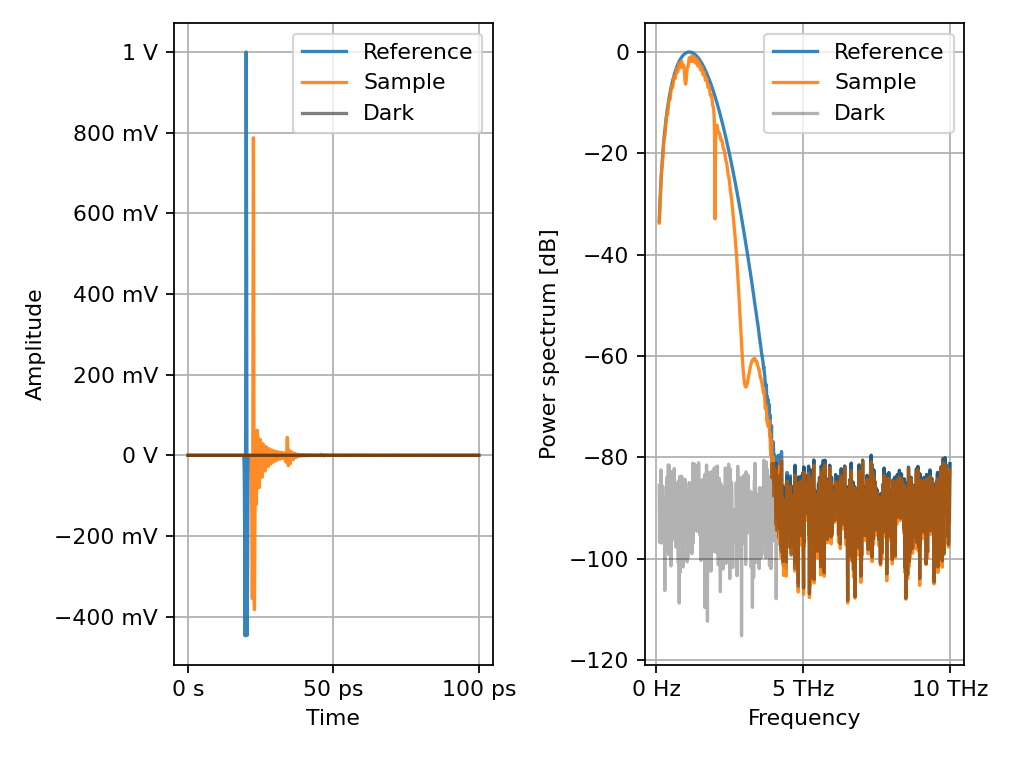

In [14]:
lower_freq = 0.1e12
upper_freq = 10e12

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(time, reference_pulse_td, alpha=0.9, label="Reference")
ax[0].plot(time, sample_pulse_td, alpha=0.9, label="Sample")
ax[0].plot(time, dark_td, alpha=0.5, color="black", label="Dark")
ax[0].legend(loc="upper right")
ax[0].grid(True)
ax[0].xaxis.set_major_formatter(EngFormatter("s"))
ax[0].set_xlabel("Time")
ax[0].yaxis.set_major_formatter(EngFormatter("V"))
ax[0].set_ylabel("Amplitude")

filter_frequency = (f > lower_freq) & (f < upper_freq)
# Normalize the spectrum
ref_power_spectrum_max = np.max(20 * np.log10(np.abs(reference_pulse_fd[filter_frequency])))
ax[1].plot(f[filter_frequency],
           20 * np.log10(np.abs(reference_pulse_fd[filter_frequency])) - ref_power_spectrum_max,
           alpha=0.9,
           label="Reference")
ax[1].plot(f[filter_frequency],
           20 * np.log10(np.abs(sample_pulse_fd[filter_frequency])) - ref_power_spectrum_max,
           alpha=0.9,
           label="Sample")
ax[1].plot(f[filter_frequency],
           20 * np.log10(np.abs(np.fft.rfft(dark_td)[filter_frequency])) - ref_power_spectrum_max,
           alpha=0.3,
           color="black",
           label="Dark")
ax[1].legend(loc="upper right")
ax[1].grid(True)
ax[1].xaxis.set_major_formatter(EngFormatter("Hz"))
ax[1].set_xlabel("Frequency")
ax[1].set_ylabel("Power spectrum [dB]")
plt.tight_layout()

## Export data
Save the data in temporary Pandas dataframes and export each trace (reference, sample, dark) to a .csv file.

In [13]:
#df = pd.DataFrame(data={"time": time, "reference": reference_pulse_td})
#df.to_csv("Artifical_Reference.txt", sep="\t", header=False, index=False)

#df = pd.DataFrame(data={"time": time, "sample": sample_pulse_td})
#df.to_csv("Artifical_Sample.txt", sep="\t", header=False, index=False)

df = pd.DataFrame(data={"time": time, "dark": dark_td})
df.to_csv("Artifical_Dark.txt", sep="\t", header=False, index=False)